# Spotify exploratory data analysis of 160k+ tracks

## Motivation 
I wouldn't dare to call myself a meloman, but I do have strong views on music, and have quite an eclectic taste. So, it's just general curiosity and itchy analytical brain that drive this analysis. 

## Hypothesis
1. Over the decades, people's taste in music changed towards more mellow music, low on daceability
2. Over the decades, the tracks became less acoustic 
3. Over the decades, the tracks became louder on average

## Tasks 
1. Clean-up (remove or impute the missing values) 
2. Find outliers and figure out what to do with them 
3. Explore correlations between the varibales 
4. Explore the correations between popuarity and audio feature variables 
5. Explore the mean picture of each decade 
6. Explore how musical features chaned over decades
7. Explore what musical features defined each decade 
8. (Bonus) Find the stringes predictor for the song's popularity

DISCLAIMER: I realise, this dataset is a sample of the whole Spotify library, and so all my conclusions about the decades will be in the context of the dataset.

## 0. Prep

In [231]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

print_checks = True

# Load the data
tracks = pd.read_csv('data.csv') # thnakfully, the encoding is UTF-8

#tracks.tail(10)

Looks good so far. Let's start cleaning.

## 1. Cleaning

In [232]:
# Let's see if the data types were infered correctly
tracks.dtypes

acousticness        float64
artists              object
danceability        float64
duration_ms           int64
energy              float64
explicit              int64
id                   object
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
name                 object
popularity            int64
release_date         object
speechiness         float64
tempo               float64
valence             float64
year                  int64
dtype: object

In [233]:
# convert bool columns to bool
tracks['explicit'] = tracks['explicit'].astype(bool)

In [234]:
# convert Mode column to category and replace labels
tracks['mode'] = tracks['mode'].astype('category')
tracks['mode'] = tracks['mode'].cat.rename_categories({1: 'Major', 0: 'Minor'})
#tracks.head()

In [235]:
# let's see what we have in release date
tracks['release_date'].sample(100)

# looks like it's missing detailes for some tracks. We have a year column, so might as well drop the release_date
tracks = tracks.drop('release_date', axis=1)

In [236]:
# let's set the index to the id column
#tracks.shape[0]
tracks.index = tracks['id']
#tracks.head()

#tracks.shape[0]
tracks = tracks.drop('id', axis=1)
#tracks.head()

In [237]:
tracks['key'].unique()
# ok, keys look good

array([10,  8,  5,  1, 11,  6,  9,  7,  4,  2,  3,  0])

In [238]:
# let's convert duration
tracks['duration'] = tracks['duration_ms']/60000
tracks = tracks.drop('duration_ms', axis=1)
#tracks.shape

In [239]:
# Let's see how many values we are missing
tracks.isna().sum().sum()

0

In [240]:
tracks.agg('min')

acousticness                                                        0
artists             ["'In The Heights' Original Broadway Company",...
danceability                                                        0
energy                                                              0
explicit                                                        False
instrumentalness                                                    0
key                                                                 0
liveness                                                            0
loudness                                                          -60
mode                                                            Major
name                                        !Que Vida! - Mono Version
popularity                                                          0
speechiness                                                         0
tempo                                                               0
valence             

Great! No missing values, everything seems to be alright. At this point the data looks good. We can continue with feature engineering. 

In [241]:
tracks['decade'] = tracks['year']//10*10
tracks['decade'] = tracks['decade'].astype('category')

# 2. Outlier detection and purging

In [242]:
tracks.describe()

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,popularity,speechiness,tempo,valence,year,duration
count,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000
mean,0.493214,0.538150,0.488593,0.161937,5.200519,0.206690,-11.370289,31.556610,0.094058,116.948017,0.532095,1977.223231,3.856769
std,0.376627,0.175346,0.267390,0.309329,3.515257,0.176796,5.666765,21.582614,0.149937,30.726937,0.262408,25.593168,2.022032
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,1921.000000,0.085133
25%,0.094500,0.417000,0.263000,0.000000,2.000000,0.098400,-14.470000,12.000000,0.034900,93.516000,0.322000,1957.000000,2.850667
50%,0.492000,0.548000,0.481000,0.000204,5.000000,0.135000,-10.474000,33.000000,0.045000,114.778000,0.544000,1978.000000,3.476667
75%,0.888000,0.667000,0.710000,0.086800,8.000000,0.263000,-7.118000,48.000000,0.075400,135.712000,0.749000,1999.000000,4.382667
max,0.996000,0.988000,1.000000,1.000000,11.000000,1.000000,3.855000,100.000000,0.969000,244.091000,1.000000,2020.000000,90.058333


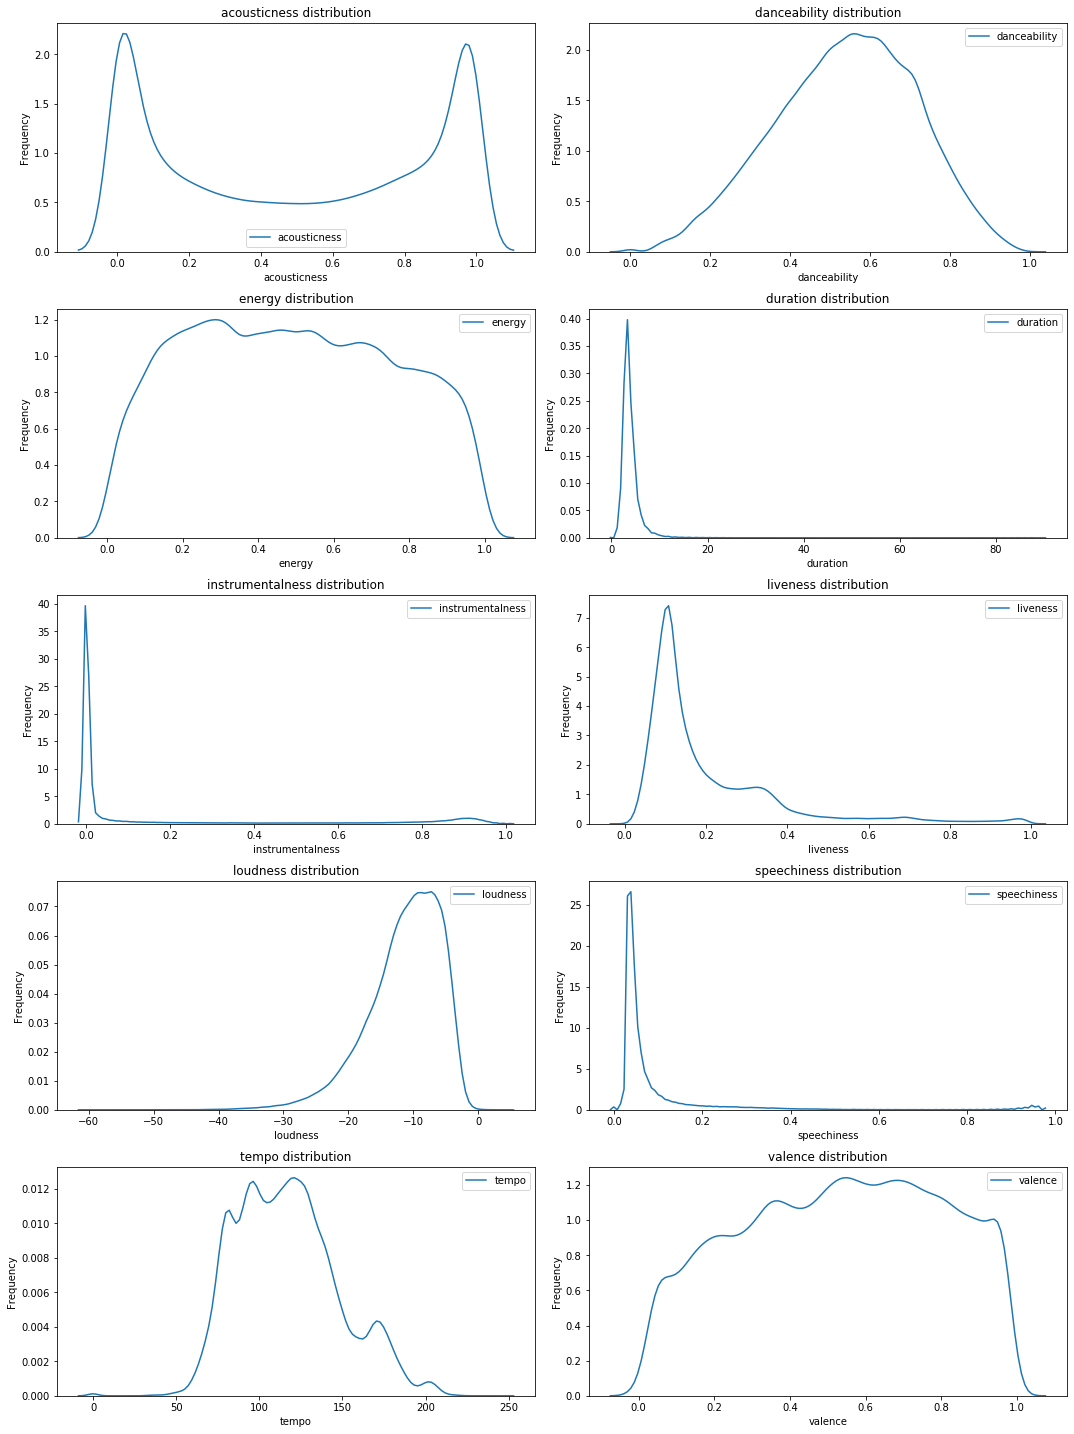

In [243]:
columns = ['acousticness', 'danceability', 'energy', 'duration', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

tracks_sample = tracks

fig = plt.figure(figsize=(15,20))
for column, i in zip(columns, range(1,len(columns)+1)):
    ax = fig.add_subplot(5,2,i)
    sns.kdeplot(tracks[column])
    plt.title('{} distribution'.format(column))
    plt.xlabel(column)
    plt.ylabel('Frequency')
fig.tight_layout(pad=1)

Seems like duration has some very long tracks (most likely concerts, audio books, podcasts, or similar), We'll cut them out. Instrumentalness, liveness, speechiness also have a sharp eft skew, but it makes sense in their case. 

In [244]:
# While there are few songs lasting over 15 minutes, those are generally outliers, and will skew our analysis, so we'll take songs shorter thaN 15 minutes
tracks = tracks[tracks['duration'] <= 15]
tracks.shape
# we lost about 0.4% of tracks

(169261, 18)

# 3. Correlations

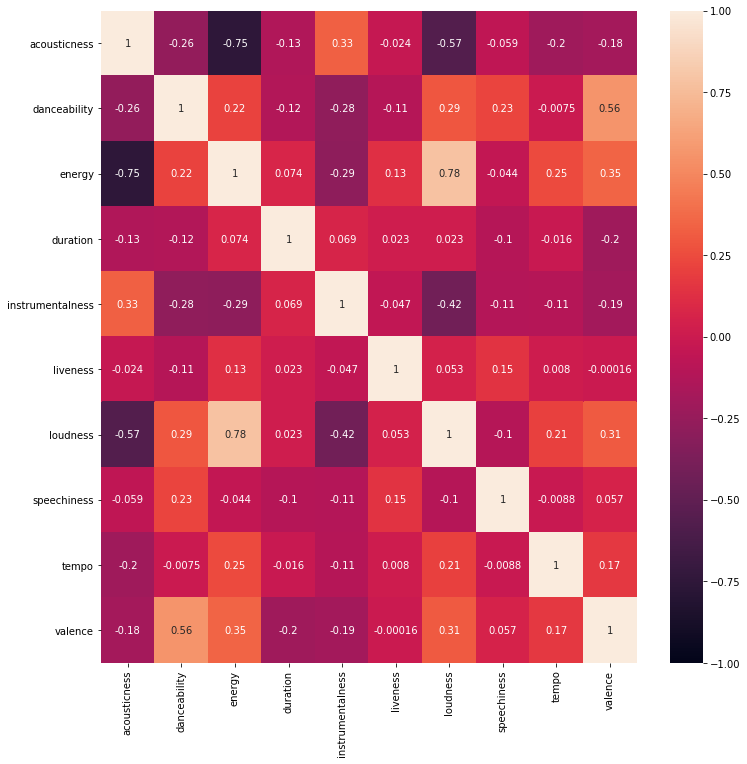

In [245]:
fig = plt.figure(figsize=(12,12))
sns.heatmap(tracks[columns].corr(), annot=True, vmin=-1, vmax=1)

Okay.Seems there are a few mid and stronger correlations. 
- Acoustic tracks tend to be lower on enegergy, which makes sense
- Acoustic tracks tend to be less loud
- Danceable tracks tend to be a tiny bit happier, more cheerful
- Energetic tracks tend to be louder

## 4. Correlation between popuarity and audio features

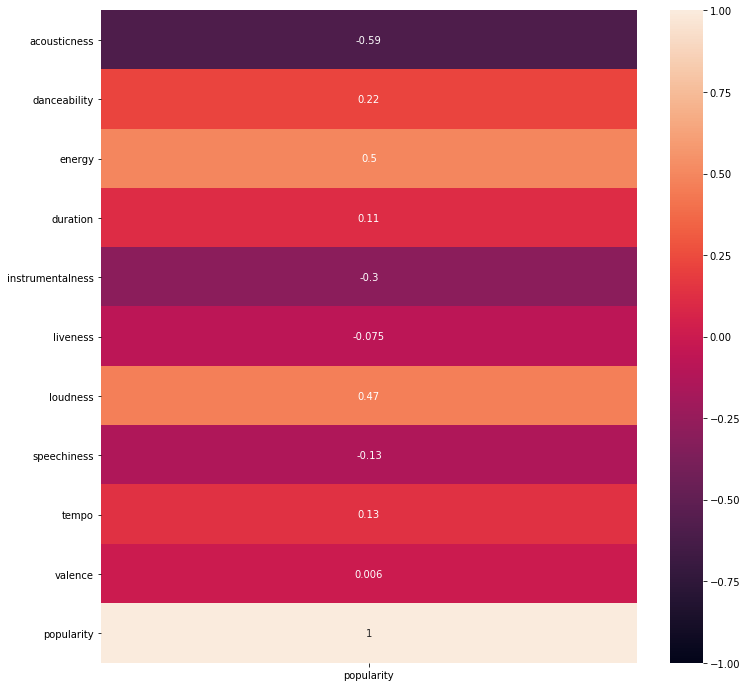

In [247]:
fig = plt.figure(figsize=(12,12))
columns_with_popularity = columns
#columns_with_popularity.append('popularity')
df = tracks[columns_with_popularity].corr()
sns.heatmap(df[['popularity']], annot=True, vmin=-1, vmax=1)

Okay. Seems like there is no stron correlations between popularity and audio features. The strongest correlation (-0.59) we got is the reverse correlation between the acosuticness and popularity. Seems like people prefer studio versions over acoustic versions. And still this corellation is pretty weak. 

**Conclusion:** correlation between popularity and audio features over last hundred or so years isn't that strong. The public tastes must have been changing a lot, or the dataset is skewed towards some variable. 

## 5. Chanage over decades

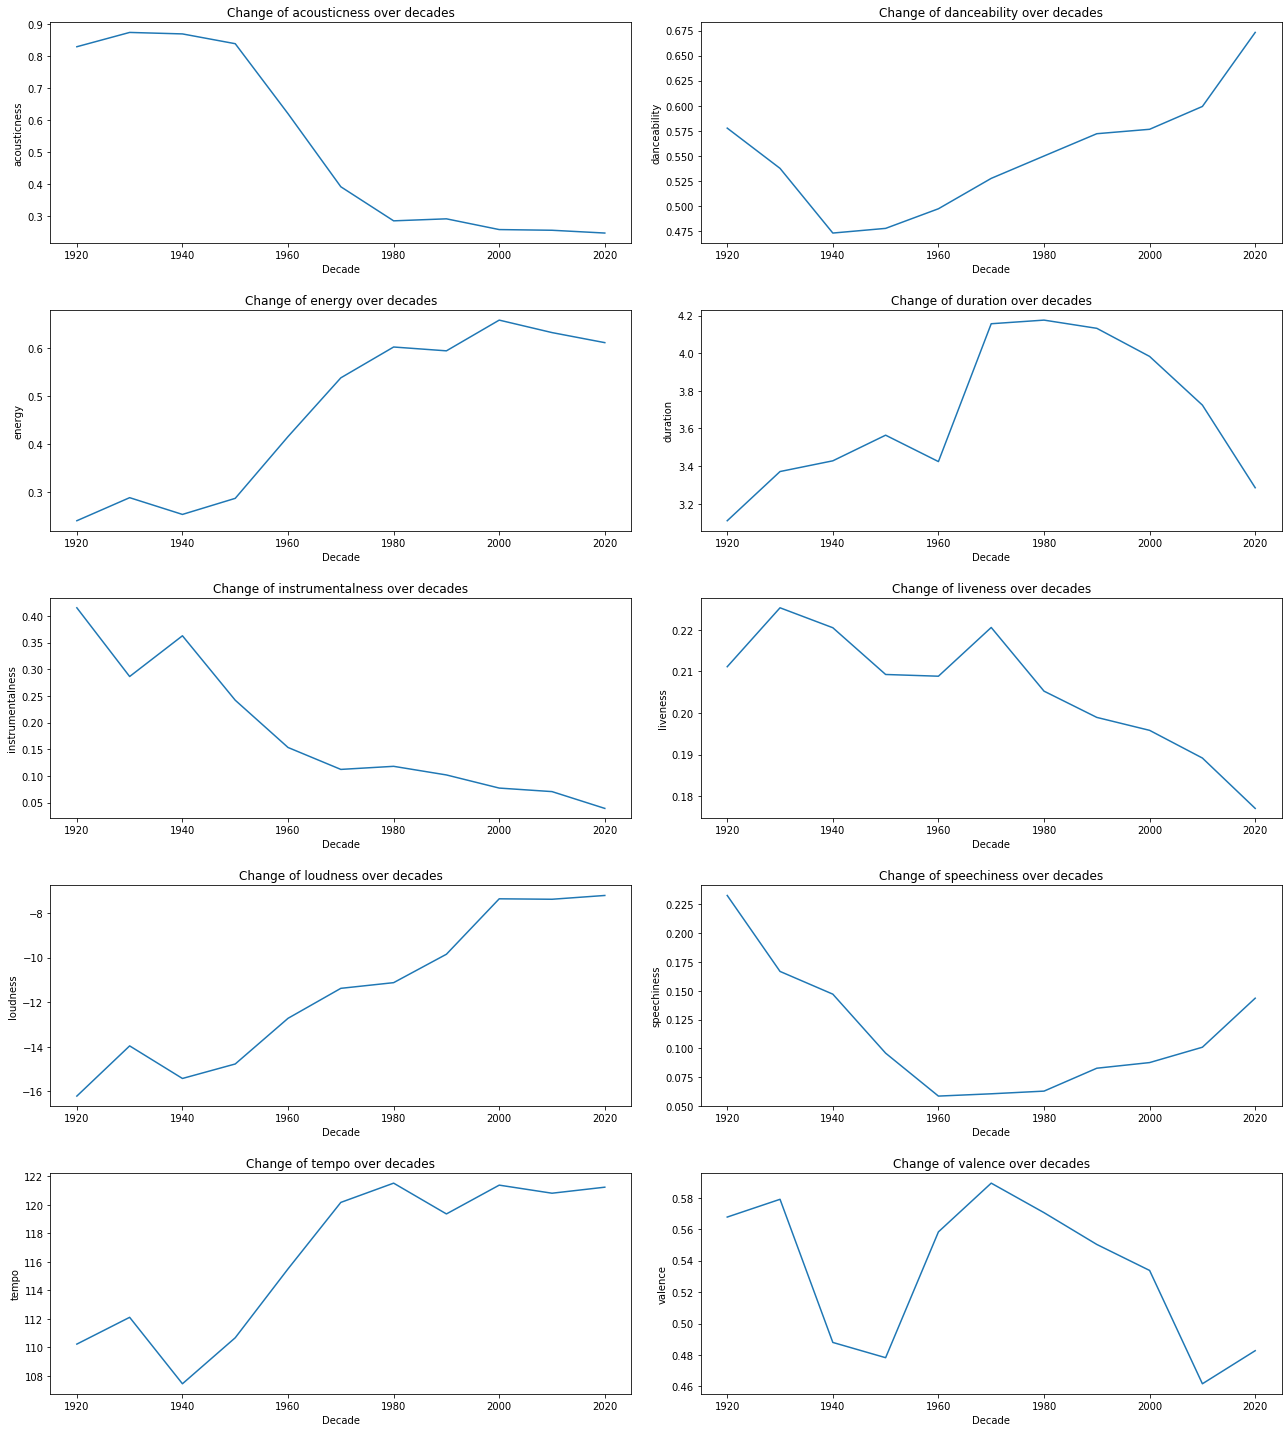

In [248]:
df = tracks.groupby('decade').mean()

df.index = df.index.astype(int)
df = df.reset_index()

fig = plt.figure(figsize=(18,20))

for col, i in zip(columns, range(1,len(columns))):
    ax = fig.add_subplot(5,2,i)
    sns.lineplot(x='decade', y=col, data=df)
    plt.title('Change of {} over decades'.format(col))
    plt.xlabel('Decade')
    plt.ylabel(col)
fig.tight_layout(h_pad=2, w_pad=2)

What we see:
- Songs have become less acoustic on average 
- Tracks have become somewhat more danceable on average 
- Tracks have become somewhat more energetic on average 
- Track length has returned to the levels of the 1920. There was a sudden increase in track length in 1970s, presumably because electronic music became a thing. Neds confirmation. 
- Tracks have become a lot less instrumental. There was a slight increase during the WWII, bus since then it was stradily declining. 
- Tracks are a little less live these days. But considering that most tracks aren't at all live, 0.04 decrease is probably because of that. 
- Tracks became less loud. Surprising! Presumably, because music reproduction technologies have become better, so there's no need to make louder songs. 
- Speechiness increased since the 1980s. Presumably, because rap and hip-hop gained wide popularity, or because podcasts have become popular in recent decades. 
- Tempo generally increased. During the 1940s there was a condiderable drop in average tempo, quite understandible. 
- The tracks were more cheerful in the 1960-1970s and then in 2010s it reached the lowest point. Whule the change is not that big, an interesting observation. 

## 6. What defined the decades

In [341]:
tracks_1940 = tracks[tracks['decade'] == 1940].copy()
tracks_1970 = tracks[tracks['decade'] == 1970].copy()
tracks_2010 = tracks[tracks['decade'] == 2010].copy()

In [342]:
labels=np.array(['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence'])

In [343]:
# we should scale the tempo and loudness columns column
def scale_minmax(df, column):
    df[column] = (df[column]-df[column].min())/(df[column].max()-df[column].min())

scale_minmax(tracks_1940,[ "tempo", "loudness"])
scale_minmax(tracks_1970,[ "tempo", "loudness"])
scale_minmax(tracks_2010,[ "tempo", "loudness"])

In [344]:
# Aggregate the columns
tracks_1940 = tracks_1940[labels].agg('mean')
tracks_1970 = tracks_1970[labels].agg('mean')
tracks_2010 = tracks_2010[labels].agg('mean')

In [345]:
angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)
# Close the plot 
tracks_1940=np.concatenate([tracks_1940,[tracks_1940.iloc[0]]])
tracks_1970=np.concatenate([tracks_1970,[tracks_1970.iloc[0]]])
tracks_2010=np.concatenate([tracks_2010,[tracks_2010.iloc[0]]])
angles=np.concatenate((angles,[angles[0]]))

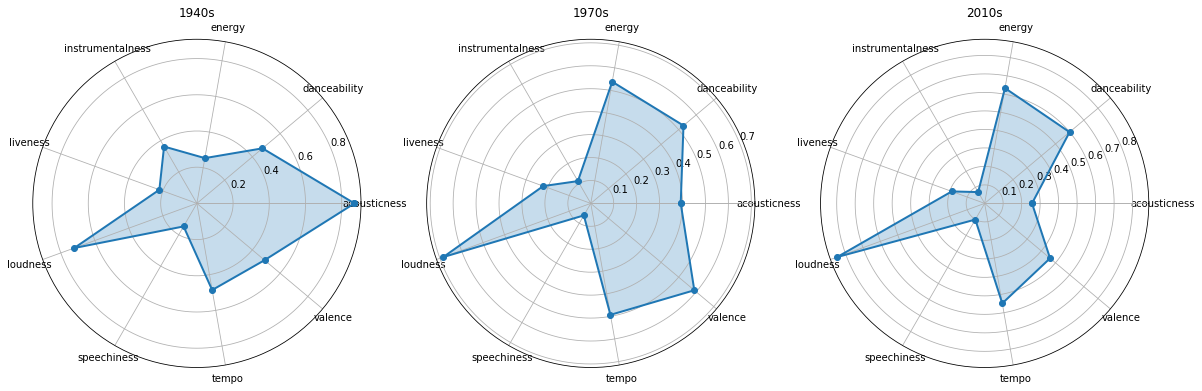

In [346]:
fig=plt.figure(figsize=(20,20))

for i,data,title in zip(range(1,4), [tracks_1940,tracks_1970,tracks_2010], ['1940s', '1970s', '2010s']):
    ax = fig.add_subplot(1,3,i, polar=True)
    ax.plot(angles, data, 'o-', linewidth=2)
    ax.fill(angles, data, alpha=0.25)
    ax.set_thetagrids(angles * 180/np.pi, labels)
    ax.set_title(title)
    ax.grid(True)


Looks like the 1940s were indeed more acoustic, slow tempo, low energy, not very cheerful, and not that danceable. World War Two might have something to do with that. Or maybe just the data source contains such songs, which don't paint a realistic picture of that decade. More research is needed for definitive answer. 

The 1970s were loud, energetic, danceable, very cheerful, high-tempo. Certainly confirms the stereotypical image of the 70s with disco and electronic music boom. Again, might be the fault in the data source, as these kinds of songs are more abundant from that decade.

The 2010s were also loud. They were alsomostly energetic, high-tempo, and danceable. But, the cheerfulness (valence) was around the 1940s level. Interesting. 2010s were an turbulent decade in regard to social issues, so the music does reflect that somewhat. Personally I didn't notice the artists that I listen to fit this plot.